In [31]:
import pandas as pd
import numpy as np
import math

env = "Varinia"

In [32]:
if env == "Sky":
    data_path_1='../Expert_response/all_HIT_answer.csv'
    data_path_2='../Expert_response/master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'

else:
    data_path_1=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\all_HIT_answer.csv'
    data_path_2=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'
    data_path_3=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\gs_response_Jun-04-2023.csv'

df_1= pd.read_csv(data_path_1)
df_2= pd.read_csv(data_path_2)
df_3= pd.read_csv(data_path_3)

In [33]:
def process_data(df_1, df_2):
    # Remove all positive and negative attention checks, keep only 1 copy of the positive attention check
    all_test_q = df_1[(df_1['question_type'] != "neg_attention") & (df_1['question_type'] != "pos_attention_easy")].copy()
    pos_attention_q = df_1[df_1['question_type'] == "pos_attention_easy"].head(1).copy()

    # Concatenate the dataframes and reset the index
    all_q = pd.concat([all_test_q, pos_attention_q], ignore_index=True)
    all_q.reset_index(drop=True, inplace=True)

    # Select the desired columns and convert question_num to int
    all_q2 = all_q[['cow_L', 'cow_R', 'question_num', 'HIT']].copy()
    all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)

    # Select the columns for response dataframe
    all_q_col = [f"q{i}" for i in range(1, 13)]
    all_col = all_q_col.copy()
    all_col.append('HIT')

    # Get the response dataframe
    response = df_2[all_col].copy()

    return all_q2, response


In [34]:
def reshape_and_remove_nan(df):
    df_melted = df.melt(id_vars='HIT',
                        value_vars=['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12'],
                        var_name='question_num',
                        value_name='response')
    df_melted['question_num'] = df_melted['question_num'].str[1:].astype(int)
    df_melted = df_melted.dropna()
    return df_melted

In [35]:
def process_and_merge(df_1, df_2):
    all_q2, response = process_data(df_1, df_2)
    response_melted = reshape_and_remove_nan(response)
    merged_df = all_q2.merge(response_melted, on=['HIT', 'question_num'], how='inner')
    merged_df2 = merged_df[['cow_L', 'cow_R', 'response']]

    return merged_df2


In [36]:
final_df=process_and_merge(df_1, df_2)
display(final_df)

C:\Users\varin\AppData\Local\Temp\ipykernel_14344\1855475665.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)


,cow_L,cow_R,response
0,6029,7138,-1.0
1,5087,4008,-3.0
2,6092,7114,0.0
3,6053,6088,1.0
4,4035,7060,-1.0
...,...,...,...
430,5087,5064,-1.0
431,6046,4035,2.0
432,7109,7153,-1.0
433,6068,5118,-1.0


In [37]:
def simple_responses(df):
    N=df.shape[0]
    matrix=[]
    for i in range(N):
        aux_df=df.iloc[[i]]
        cow_L=aux_df.at[i,'cow_L']
        cow_R=aux_df.at[i,'cow_R']
        response=aux_df.at[i,'response']
        if response==0:
            row=np.concatenate(([cow_L],[cow_R],[0]))
        elif response<0:
            row=np.concatenate(([cow_L],[cow_R],[-1]))
        else:
            row=np.concatenate(([cow_L],[cow_R],[1]))
        matrix.append(row.tolist())
    new_df=pd.DataFrame(matrix)
    new_df.columns=['cow_L', 'cow_R', 'response']

    return new_df

In [38]:
responses=simple_responses(final_df)
display(responses)

,cow_L,cow_R,response
0,6029,7138,-1
1,5087,4008,-1
2,6092,7114,0
3,6053,6088,1
4,4035,7060,-1
...,...,...,...
430,5087,5064,-1
431,6046,4035,1
432,7109,7153,-1
433,6068,5118,-1


In [39]:
def list_cows(df):
    first_cow=df.loc[0,'cow_L']
    aux_df=df[df['cow_L']==first_cow]
    cows_1=list(aux_df['cow_R'])
    aux_df=df[df['cow_R']==first_cow]
    cows_2=list(aux_df['cow_L'])
    for i in cows_2:
        cows_1.append(i)
    cows_1.append(first_cow)
    return cows_1

In [40]:
cow_order=list_cows(responses)
print(cow_order)
print(len(cow_order))

[7138, 6062, 8083, 7128, 6025, 7153, 4035, 6092, 4026, 6086, 6094, 7060, 7116, 6088, 7163, 5064, 6095, 7136, 7114, 4008, 7064, 6053, 5118, 6096, 7109, 6046, 6068, 5087, 7045, 6029]
30


In [41]:
def matrix_comparison(df):
    cow_order=list_cows(df)
    num_cows=len(cow_order)
    data_comp=np.zeros( (num_cows, num_cows) )
    for i in range(num_cows):
        for j in range(num_cows):
            if (i==j):
                data_comp[i][j]=np.nan
            else:
                aux=df[(df['cow_L']==cow_order[i])|(df['cow_R']==cow_order[i])]
                aux=aux[(aux['cow_L']==cow_order[j])|(aux['cow_R']==cow_order[j])]
                #print(aux)
                cow_L=aux['cow_L'].to_numpy()
                cow_R=aux['cow_R'].to_numpy()
                response=aux['response'].to_numpy()
                if(response[0]==0):
                    data_comp[i][j]=0
                else:        
                    if(cow_L[0]==cow_order[i]):
                        if(response[0]<0):
                            data_comp[i][j]=1
                        else: 
                            data_comp[i][j]=-1
                    else: #aux['cow_L']==cow_order[j]
                        if(response[0]<0):
                            data_comp[i][j]=-1
                        else: 
                            data_comp[i][j]=1
    data_comp = pd.DataFrame(data_comp)
    return data_comp 

In [42]:

def mergeSort(lst,comp,data_comparison):
    if len(lst) > 1:
        r = len(lst)//2
        L = lst[:r]
        M = lst[r:]
        L,comp=mergeSort(L,comp,data_comparison)
        M,comp=mergeSort(M,comp,data_comparison)
        lst=L+M
        i = j = k = 0

        while i < len(L) and j < len(M):
            comp += 1
            if data_comparison[L[i][0]][M[j][0]]==1 :
                lst[k] = L[i]
                i += 1
            else:
                lst[k] = M[j]
                j += 1
            k += 1

        while i < len(L):
            lst[k] = L[i]
            i += 1
            k += 1

        while j < len(M):
            lst[k] = M[j]
            j += 1
            k += 1
    return lst,comp


In [43]:
data_comparison = matrix_comparison(responses)
display(data_comparison)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,1.0,0.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,...,0.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0
1,-1.0,NaN,1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,...,0.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0
2,0.0,-1.0,NaN,0.0,1.0,-1.0,1.0,1.0,0.0,-1.0,...,1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
3,1.0,0.0,0.0,NaN,1.0,1.0,-1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.0,1.0,1.0
4,-1.0,1.0,-1.0,-1.0,NaN,1.0,-1.0,0.0,-1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,-1.0,0.0,1.0
5,-1.0,1.0,1.0,-1.0,-1.0,NaN,-1.0,0.0,1.0,-1.0,...,1.0,1.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,1.0
6,1.0,1.0,-1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,NaN,-1.0,-1.0,...,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0
8,1.0,1.0,0.0,-1.0,1.0,-1.0,-1.0,1.0,NaN,1.0,...,0.0,1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,1.0,1.0
9,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,NaN,...,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0


In [44]:
num_cows=len(cow_order)
print("Cow order in matrix is:")
print(cow_order)

lst_mg = []
for i in range(num_cows):
    inner_list = []
    inner_list.append(i)
    lst_mg.append(inner_list)

print("Basic array before mergesort:")    
print(lst_mg)

comp_mg=0
lst_mg,comp_mg= mergeSort(lst_mg,comp_mg,data_comparison)
lst_mg,comp_mg=mergeSort(lst_mg,comp_mg,data_comparison)
print("Basic array sorted after mergesort:")

print(lst_mg)
lst_mg_cows=[]
while (len(lst_mg)>0):
    aux_len=len(lst_mg[0])
    aux_ties=[]
    for i in range(aux_len):
        aux_ties.append(cow_order[lst_mg[0][i]]) 
    lst_mg.pop(0)  
    lst_mg_cows.append(aux_ties)
print("Sorted cows in ascending order is:")
print(lst_mg_cows)

print("Number of comparisons done in merge sort:")
print(comp_mg)


Cow order in matrix is:
[7138, 6062, 8083, 7128, 6025, 7153, 4035, 6092, 4026, 6086, 6094, 7060, 7116, 6088, 7163, 5064, 6095, 7136, 7114, 4008, 7064, 6053, 5118, 6096, 7109, 6046, 6068, 5087, 7045, 6029]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[21], [7], [20], [8], [5], [25], [4], [28], [29], [17], [26], [3], [22], [16], [0], [10], [14], [9], [18], [11], [2], [1], [23], [24], [19], [13], [15], [12], [27], [6]]
Sorted cows in ascending order is:
[[6053], [6092], [7064], [4026], [7153], [6046], [6025], [7045], [6029], [7136], [6068], [7128], [5118], [6095], [7138], [6094], [7163], [6086], [7114], [7060], [8083], [6062], [6096], [7109], [4008], [6088], [5064], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
204


In [45]:
#6095 not a 4
#6029 not a 4
#7128 not a 2
mg_vs_GS = pd.DataFrame([item for sublist in lst_mg_cows for item in sublist], columns=['merge sorted'])
N=mg_vs_GS.shape[0]
aux=[]
for i in range (N):
    cow=mg_vs_GS.at[i,'merge sorted']
    aux.append(list(df_3.loc[df_3['Cow']== cow,'GS'])[0])
mg_vs_GS['GS'] = aux
print(mg_vs_GS)

    merge sorted  GS
0           6053   3
1           6092   2
2           7064   2
3           4026   2
4           7153   2
5           6046   3
6           6025   2
7           7045   2
8           6029   2
9           7136   2
10          6068   2
11          7128   3
12          5118   2
13          6095   3
14          7138   2
15          6094   2
16          7163   2
17          6086   2
18          7114   2
19          7060   3
20          8083   3
21          6062   2
22          6096   3
23          7109   2
24          4008   2
25          6088   3
26          5064   2
27          7116   2
28          5087   4
29          4035   3


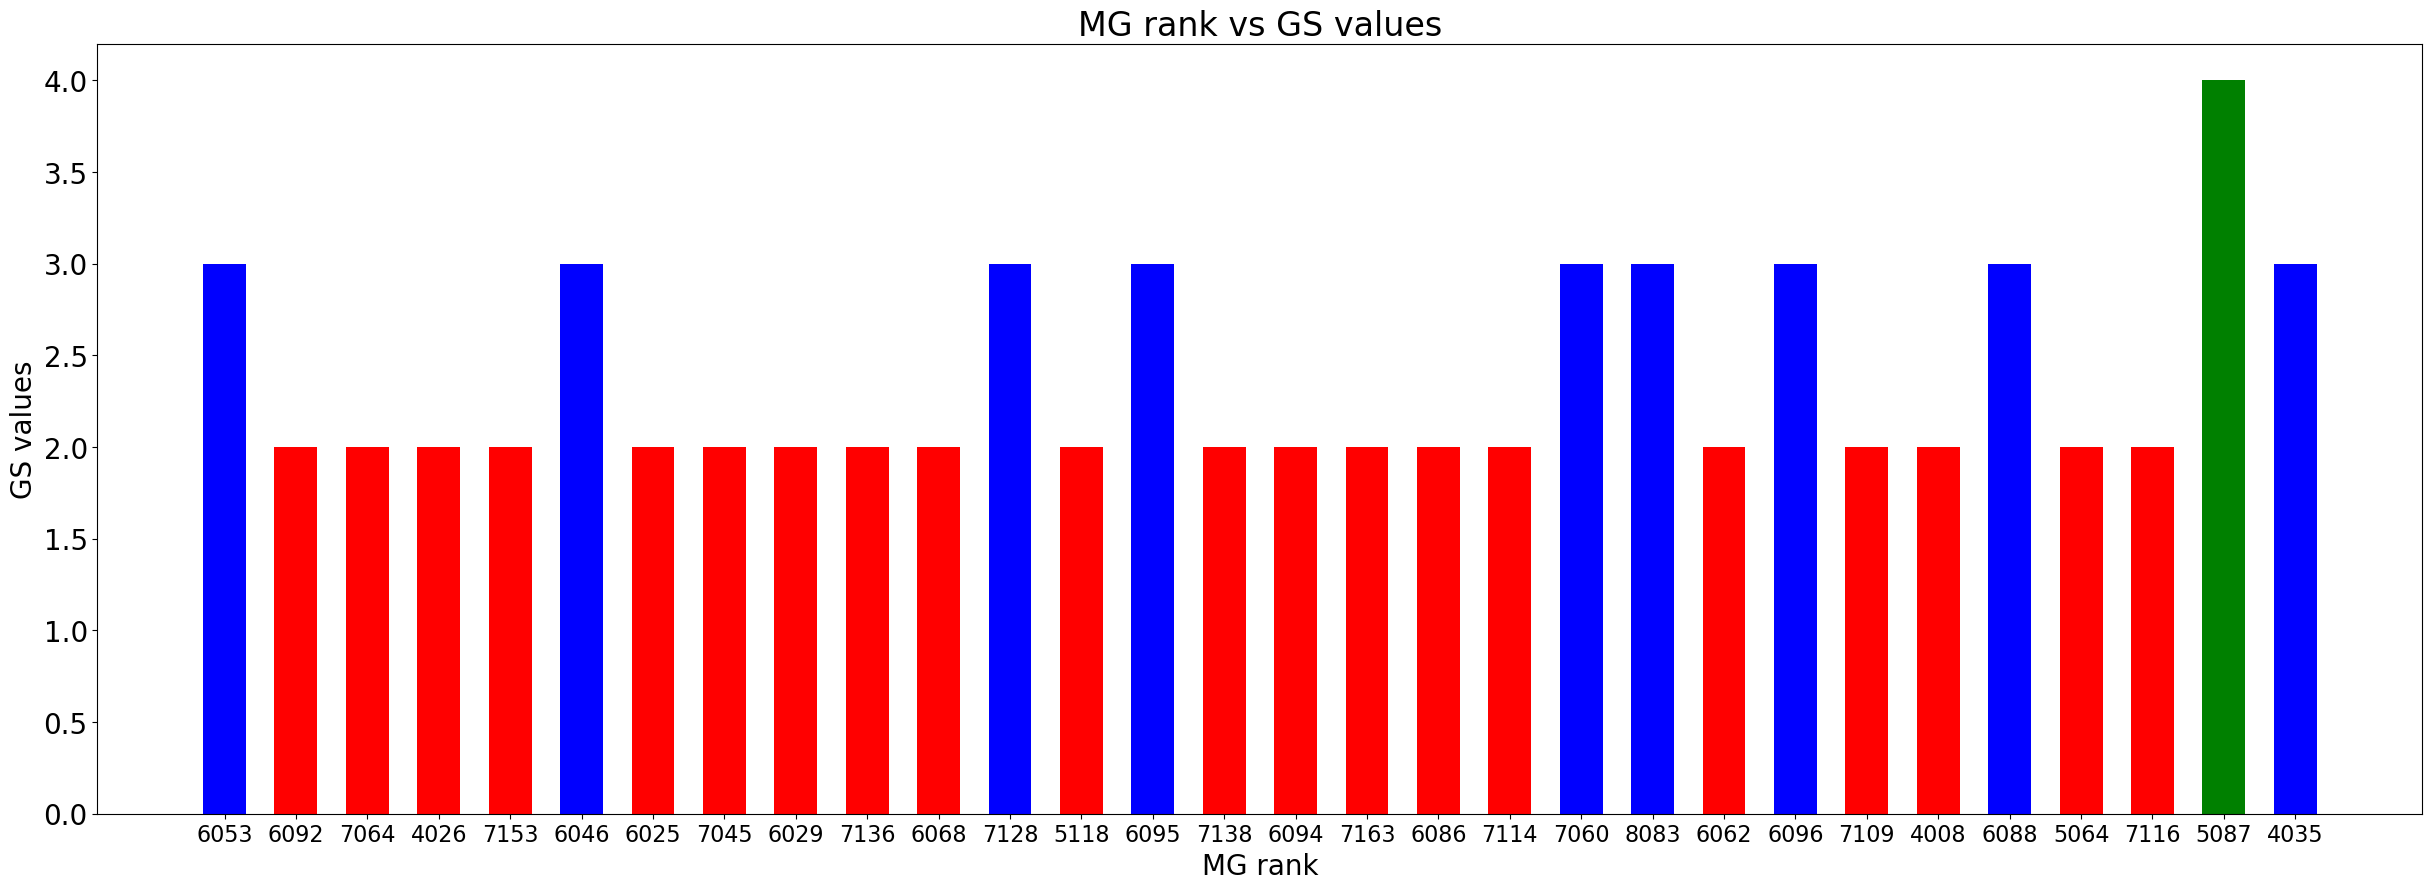

In [46]:
import matplotlib.pyplot as plt
x=list(mg_vs_GS['merge sorted'])
y=list(mg_vs_GS['GS'])
string_cow = [str(item) for item in x]
# Get unique y-axis values
unique_values = np.unique(y)

# Define the colors for each unique y-axis value
colors = {'2': 'red', '3': 'blue', '4': 'green'}

plt.figure(figsize=(30, 10))

plt.bar(string_cow, y, color=[colors[str(val)] for val in y], width=0.6)

plt.xlabel('MG rank', fontsize=20)
plt.ylabel('GS values', fontsize=20)
plt.title('MG rank vs GS values', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.show()
